In [1]:
import pandas as pd
from core.repository import load_financial
from base.timeutil import YearMonth
import sqlite3
from core.repository.maria.conn import maria_home

db_file = "analysis.db"

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(db_file))
except:
    print("Fetching month chart...")
    month_chart = pd.read_sql("""
        select month_chart.*, stock.name, stock.exchange from month_chart
        join stock on month_chart.code = stock.code;
    """, maria_home())
    print("Building layer1...")

    begin = YearMonth(2002, 4)
    end = YearMonth(2023, 4)

    month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.to(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
        df1 = df1[df1["val_last"] >= 1000_0000]
        df2.loc[df2["val_last"] == 0, "close"] = df2[df2["val_last"] == 0]["close"] / 5

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
            "거래대금": df1["val"],
            "전월수익률": df1["close"] / df1["open"] - 1
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1
        # 재무데이터 조인하여 layer1에 반영
        fn = load_financial(ym1.year, ym1.month)
        layer1 = pd.concat([layer1, df.join(fn)])

    layer1 = layer1.reset_index()
    layer1["확정실적"] = layer1["확정실적"].apply(str)
    layer1.to_sql("layer1", sqlite3.connect(db_file), if_exists="replace", index=False)

layer1

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,거래대금,...,E_QoQ,R/A_QoQ,GP/A_QoQ,O/A_QoQ,E/A_QoQ,R/EQ_QoQ,GP/EQ_QoQ,O/EQ_QoQ,E/EQ_QoQ,확정실적
0,060310,3S,코스닥,2002-04,2002-05,14328000000,2002-04-30,2604,1480725,12071273140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,006840,AK홀딩스,유가증권,2002-04,2002-05,108300000000,2002-04-30,11302,706504,15311799550,...,2.151386,0.039735,0.013609,0.007998,0.012766,0.081359,0.027205,0.015848,0.025052,2001-4Q
2,054620,APS,코스닥,2002-04,2002-05,20934600000,2002-04-30,6162,3623832,41050604910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3,001460,BYC,유가증권,2002-04,2002-05,38413822500,2002-04-30,61500,73712,5506711000,...,-0.608231,-0.011676,-0.001393,0.003334,-0.017559,-0.014840,-0.001662,0.004425,-0.023219,2001-4Q
4,001040,CJ,유가증권,2002-04,2002-05,1250135164800,2002-04-30,28006,4513180,263372467300,...,1.157134,0.248107,0.137269,0.058049,0.032612,0.635466,0.395791,0.181644,0.106711,2001-4Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389473,189980,흥국에프엔비,코스닥,2023-03,2023-04,109174889440,2023-03-31,2720,4793251,13321516235,...,0.349857,-0.040107,-0.014214,-0.004336,-0.003231,0.021607,0.007003,0.005584,0.006135,2022-3Q
389474,000540,흥국화재,유가증권,2023-03,2023-04,204291611100,2023-03-31,3180,1993371,6854371810,...,NaN,0.005376,NaN,0.001088,NaN,0.380950,NaN,0.033848,NaN,2022-3Q
389475,003280,흥아해운,유가증권,2023-03,2023-04,331545935721,2023-03-31,1379,3590072,5045791486,...,8.103269,0.085515,0.043808,0.042733,0.018525,0.229167,0.108547,0.102940,0.046502,2022-3Q
389476,037440,희림,코스닥,2023-03,2023-04,126972972000,2023-03-31,9120,15461656,152143635870,...,2.517199,-0.004923,0.011450,0.005833,0.010255,-0.045885,0.030324,0.016097,0.028984,2022-3Q


In [108]:

import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
        "자산총계": "A",
        "자본총계": "EQ",

        "매출액": "R",
        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
    }
)

factors = [
    "BIS",
    "BIS_QoQ",
    "전월수익률",
    "E_YoY",
    "O_YoY"
]

for x in ["R", "GP", "O", "E"]:
    for y in ["", "/A", "/EQ"]:
        factors.append(f"{x}{y}_QoQ")

for pos in ["R", "GP", "O", "E", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["A", "EQ"]:
    for pos in ["R", "GP", "O", "E"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("P")

layer2["TV/P"] = layer2["TV"] / layer2["P"]
factors.append("TV/P")

result = pd.DataFrame()
yms = layer2["매수년월"].unique()

recipes = {
    "v3": {
        "P": -8,
        "GP/P": 4,
        "EQ/P": 4,
        "R_QoQ": 1,
        "GP_QoQ": 1,
        "O_QoQ": 1,
        "E_QoQ": 1,
        "R/A_QoQ": 1,
        "GP/A_QoQ": 1,
        "O/A_QoQ": 1,
        "E/A_QoQ": 1
    },
    "성장_단순이익": {f"{e}_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_자산대비이익": {f"{e}/A_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_자본대비이익": {f"{e}/EQ_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_매출종합": {f"R{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_매출총이익종합": {f"GP{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_영업이익종합": {f"O{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_순이익종합": {f"E{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_YoY": {"E_YoY": 1, "O_YoY": 1},
    "성장": {
        "성장_매출총이익종합": 5,
        "성장_영업이익종합": 4,
        "성장_순이익종합": 3,
        "성장_매출종합": 2,
    },
    "벨류": {
        "GP/P": 1,
        "EQ/P": 1,
    },
    "전략": {
        "P": -1,
        "성장": 1,
        "벨류": 1,
    },
}

print(pd.DataFrame(recipes))

for ym in yms:
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        colname_pct = f"{factor}_pct"
        df[colname_pct] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    for title, recipe in recipes.items():
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else (1 - df[f"{k}_pct"]) * abs(w) for k, w in recipe.items()])
        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[title] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(method="min", pct=True) * 100)  # todo: ceil 빼고 백테스트

    result = pd.concat([result, df])

factors = list(recipes.keys()) + factors
result

             v3  성장_단순이익  성장_자산대비이익  성장_자본대비이익  성장_매출종합  성장_매출총이익종합  \
P          -8.0      NaN        NaN        NaN      NaN         NaN   
GP/P        4.0      NaN        NaN        NaN      NaN         NaN   
EQ/P        4.0      NaN        NaN        NaN      NaN         NaN   
R_QoQ       1.0      1.0        NaN        NaN      1.0         NaN   
GP_QoQ      1.0      1.0        NaN        NaN      NaN         1.0   
O_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
E_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
R/A_QoQ     1.0      NaN        1.0        NaN      1.0         NaN   
GP/A_QoQ    1.0      NaN        1.0        NaN      NaN         1.0   
O/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
E/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
R/EQ_QoQ    NaN      NaN        NaN        1.0      1.0         NaN   
GP/EQ_QoQ   NaN      NaN        NaN        1.0      NaN         1.0   
O/EQ_Q

,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,TV,...,성장_순이익종합,성장_순이익종합_pct,성장_YoY,성장_YoY_pct,성장,성장_pct,벨류,벨류_pct,전략,전략_pct
0,060310,3S,코스닥,2002-04,2002-05,14328000000,2002-04-30,2604,1480725,12071273140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,006840,AK홀딩스,유가증권,2002-04,2002-05,108300000000,2002-04-30,11302,706504,15311799550,...,77.000000,77.0,70.5,74.0,73.642857,83.0,54.5,55.0,19.666667,54.0
2,054620,APS,코스닥,2002-04,2002-05,20934600000,2002-04-30,6162,3623832,41050604910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001460,BYC,유가증권,2002-04,2002-05,38413822500,2002-04-30,61500,73712,5506711000,...,28.333333,27.0,53.0,53.0,50.357143,52.0,93.0,96.0,32.000000,76.0
4,001040,CJ,유가증권,2002-04,2002-05,1250135164800,2002-04-30,28006,4513180,263372467300,...,84.000000,88.0,99.5,100.0,96.857143,100.0,66.5,71.0,25.000000,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389473,189980,흥국에프엔비,코스닥,2023-03,2023-04,109174889440,2023-03-31,2720,4793251,13321516235,...,55.666667,55.0,68.5,73.0,50.785714,51.0,51.5,50.0,19.666667,56.0
389474,000540,흥국화재,유가증권,2023-03,2023-04,204291611100,2023-03-31,3180,1993371,6854371810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389475,003280,흥아해운,유가증권,2023-03,2023-04,331545935721,2023-03-31,1379,3590072,5045791486,...,90.666667,94.0,50.5,50.0,98.285714,100.0,21.5,16.0,13.666667,43.0
389476,037440,희림,코스닥,2023-03,2023-04,126972972000,2023-03-31,9120,15461656,152143635870,...,83.333333,83.0,62.5,66.0,73.714286,79.0,37.0,33.0,21.666667,61.0


['v3', '성장_단순이익', '성장_자산대비이익', '성장_자본대비이익', '성장_매출종합', '성장_매출총이익종합', '성장_영업이익종합', '성장_순이익종합', '성장_YoY', '성장', '벨류', '전략']
[12/12] 전략YoY종합합합
2002-04 2023-04
             v3  성장_단순이익  성장_자산대비이익  성장_자본대비이익  성장_매출종합  성장_매출총이익종합  \
P          -8.0      NaN        NaN        NaN      NaN         NaN   
GP/P        4.0      NaN        NaN        NaN      NaN         NaN   
EQ/P        4.0      NaN        NaN        NaN      NaN         NaN   
R_QoQ       1.0      1.0        NaN        NaN      1.0         NaN   
GP_QoQ      1.0      1.0        NaN        NaN      NaN         1.0   
O_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
E_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
R/A_QoQ     1.0      NaN        1.0        NaN      1.0         NaN   
GP/A_QoQ    1.0      NaN        1.0        NaN      NaN         1.0   
O/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
E/A_QoQ     1.0      NaN        1.0        NaN      NaN        

,spearman,kendall,h3,h5,h10,t3,t5,t10,mdd5,h3-t3,h10-t10,h3-t3+mdd3,h10-t10+mdd10,mean,median,strength
factor,,,,,,,,,,,,,,,,
v3,0.958212,0.835960,0.503873,0.480015,0.434409,-0.137254,-0.120046,-0.090349,-0.507538,0.641127,0.524757,0.139442,0.029829,0.113528,0.076031,0.886431
전략,0.948875,0.823434,0.481128,0.460154,0.413932,-0.134082,-0.108222,-0.093157,-0.507181,0.615210,0.507088,0.101169,0.011017,0.114421,0.078338,0.807693
벨류,0.918320,0.756768,0.266139,0.256549,0.244106,-0.142838,-0.145851,-0.088866,-0.568801,0.408977,0.332971,-0.174070,-0.214015,0.107112,0.116516,0.311092
성장,0.920924,0.759596,0.236440,0.230863,0.230130,-0.107236,-0.090229,-0.053746,-0.566594,0.343676,0.283875,-0.222799,-0.288850,0.094493,0.086474,0.227585
성장_자산대비이익,0.891917,0.719192,0.202964,0.232231,0.229912,-0.080243,-0.080239,-0.047797,-0.538891,0.283208,0.277708,-0.282721,-0.265591,0.094911,0.092434,0.200183
성장_단순이익,0.905359,0.727677,0.217588,0.213904,0.220090,-0.063371,-0.064545,-0.043714,-0.557855,0.280959,0.263805,-0.305946,-0.279085,0.095236,0.086440,0.185591
성장_자본대비이익,0.848089,0.669495,0.193402,0.205770,0.219106,-0.068717,-0.058401,-0.041996,-0.608654,0.262119,0.261102,-0.342366,-0.318687,0.093533,0.093892,0.157009
성장_매출총이익종합,0.878344,0.697778,0.165185,0.186622,0.200351,-0.111642,-0.083323,-0.048811,-0.606979,0.276827,0.249163,-0.367015,-0.338272,0.095663,0.098749,0.154222
성장_영업이익종합,0.849913,0.667071,0.194487,0.191751,0.196983,-0.112018,-0.077968,-0.054805,-0.599617,0.306505,0.251787,-0.258604,-0.338149,0.093696,0.089537,0.145891


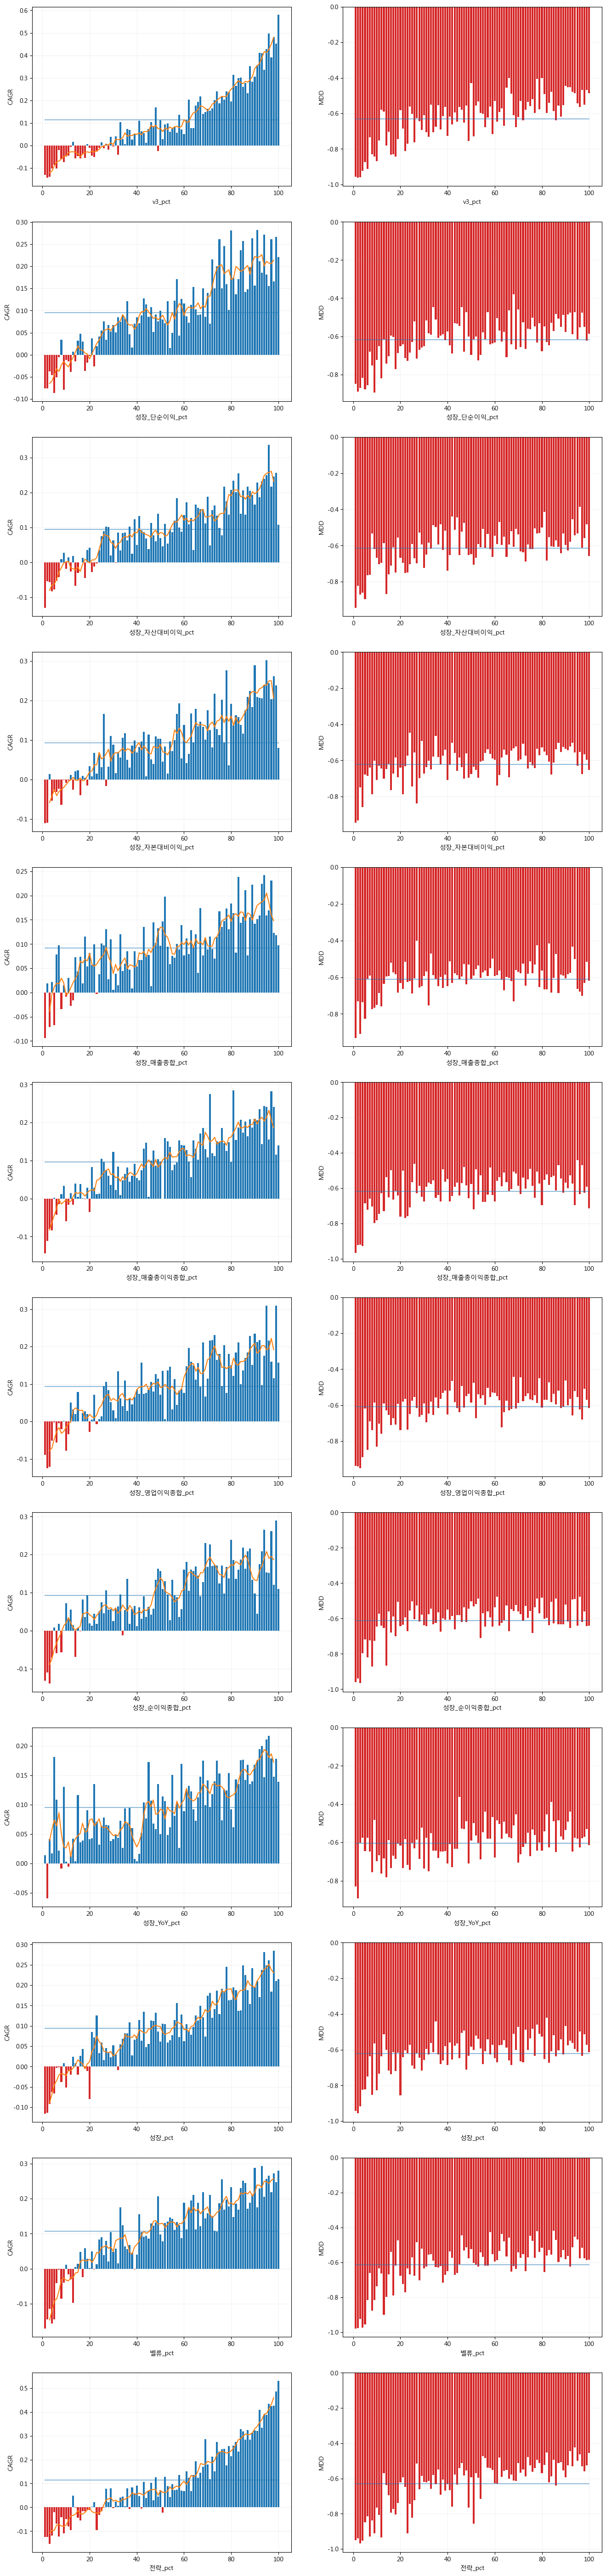

In [110]:
import matplotlib.pyplot as plt
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth
from datetime import date

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

# target_factors = [f for f in factors if "성장" in f]
target_factors = list(recipes.keys())
print(target_factors)

fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))

summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname_pct = f"{factor}_pct"
    percentiles = sorted(set(result[colname_pct].dropna()))
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in percentiles:
        by_pct = result[result[colname_pct] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(by_pct["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, last, by_pct["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_pct_series = pd.Series(cagr_by_pct)
    mdd_by_pct_series = pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname_pct)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(percentiles, cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(percentiles, [cagr_by_pct_series.mean() for _ in percentiles], alpha=0.5)
    ax1.plot(percentiles, cagr_by_pct_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_pct)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(percentiles, mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(percentiles, [mdd_by_pct_series.mean() for _ in percentiles], alpha=0.5)

    spearman = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct_series[cagr_by_pct_series.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct_series[mdd_by_pct_series.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname_pct]["cagr"],
            "kendall": kendall[colname_pct]["cagr"],

            "h3": cagr_by_pct_desc.head(3).mean(),
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),

            "t3": cagr_by_pct_desc.tail(3).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),

            "mdd5": mdd_by_pct_desc.head(5).mean(),

            "h3-t3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),

            "h3-t3+mdd3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean() + mdd_by_pct_desc.head(
                3).mean(),
            "h10-t10+mdd10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean() + mdd_by_pct_desc.head(
                10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])

fig.savefig('test.png', bbox_inches='tight')

print()
print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))

summary.index.name = "factor"
summary.to_sql("sfw", sqlite3.connect(db_file), if_exists="replace")
summary["strength"] = pow((summary["spearman"] + summary["kendall"]) * (summary["h10"] - summary["t10"]), 2)
summary = summary.sort_values("strength", ascending=False)
summary.to_csv("summary.csv")
summary

In [105]:
# 각 월에 전략에 의해 선정된 종목의 수익률이 과거 전략 매수에 의한 수익률과 어떤 관계를 갖는지 확인
# 결론: 의미 없는것 같음

search_result = result.copy()
search_result = search_result[search_result["전략_pct"] >= 99]
search_result = search_result[["code", "종목명", "매도년월", "전략_pct", "벨류_pct", "성장_pct", "수익률"]]


def historical_returns(row):
    selector = (search_result["매도년월"] < row["매도년월"]) & (search_result["code"] == row["code"])
    return (search_result[selector]["수익률"] + 1).prod()


# effect 는 선정된 각 종목의 과거 전략에 의한 수익률이다.
search_result["effect"] = search_result.apply(lambda row: historical_returns(row), axis=1)
search_result["벤치마크 수익률"] = (result.groupby("매도년월")["수익률"]).transform('mean')
search_result["성능"] = search_result["수익률"] - search_result["벤치마크 수익률"]
print("pearson", search_result[["effect", "성능"]].corr(method="pearson").iloc[1, 0])
print("kendall", search_result[["effect", "성능"]].corr(method="kendall").iloc[1, 0])
print("spearman", search_result[["effect", "성능"]].corr(method="spearman").iloc[1, 0])
search_result

# (search_result.groupby("매도년월").apply(lambda x: x["수익률"].mean()))


pearson -0.008706408977560798
kendall -0.0016389651171413995
spearman -0.0025103304588380577


,code,종목명,매도년월,전략_pct,벨류_pct,성장_pct,수익률,effect,벤치마크 수익률,성능
73,023150,MH에탄올,2002-05,100.0,87.0,98.0,-0.013793,1.000000,-0.047674,0.033881
219,004780,대륙제관,2002-05,99.0,95.0,71.0,0.026034,1.000000,-0.047674,0.073707
251,001070,대한방직,2002-05,99.0,95.0,91.0,0.014981,1.000000,-0.047674,0.062655
267,005160,동국산업,2002-05,99.0,96.0,98.0,-0.087603,1.000000,-0.047674,-0.039930
367,011390,부산산업,2002-05,100.0,87.0,93.0,0.026563,1.000000,-0.047674,0.074236
...,...,...,...,...,...,...,...,...,...,...
389145,225590,패션플랫폼,2023-04,100.0,90.0,89.0,-0.101307,0.700898,-0.013287,-0.088021
389158,010770,평화홀딩스,2023-04,99.0,90.0,82.0,-0.002924,0.976663,-0.013287,0.010363
389269,010100,한국무브넥스,2023-04,100.0,98.0,94.0,0.168207,0.708687,-0.013287,0.181494
389319,003680,한성기업,2023-04,99.0,87.0,77.0,-0.003717,1.888623,-0.013287,0.009569


In [173]:
# 백테스트: 매매 시뮬레이션

from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

head = 20
result2 = result.copy()
result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

# todo: 필터를 전 종목 기준으로 하지말고, 전략 내에서 해보자. 예를들면, 전월수익률

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

result3 = result2.groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head).sort_values("수익률", ascending=False))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", "전월수익률", "성장_pct", "벨류_pct", f"{factor}_pct"]]
result3.to_csv("result3-2.csv")

result3

전략
          CAGR                                        MDD      Mean
전략    0.582505  (-0.4961119302740751, (2007-09, 2008-11))  0.042843
벤치마크  0.097266  (-0.5658884439667557, (2007-07, 2008-10))  0.010084


code    종목명       수익률   거래소         매수일         매도일  \
매수년월    매도년월                                                                    
2002-04 2002-05 263     012510  더존비즈온  4.506840  유가증권  2002-04-30  2002-05-31   
                645     014990   인디에프  0.542448  유가증권  2002-04-30  2002-05-31   
                488     005390   신성통상  0.128617  유가증권  2002-04-30  2002-05-31   
                648     006490   인스코비  0.069155  유가증권  2002-04-30  2002-05-31   
                377     003960   사조대림  0.060615  유가증권  2002-04-30  2002-05-31   
...                        ...    ...       ...   ...         ...         ...   
2023-03 2023-04 389145  225590  패션플랫폼 -0.101307   코스닥  2023-03-31  2023-04-28   
                387205  123700    SJM -0.113548  유가증권  2023-03-31  2023-04-28   
                388106  115570  스타플렉스 -0.119510   코스닥  2023-03-31  2023-04-28   
                387820  046310  백금T&A -0.167164   코스닥  2023-03-31  2023-04-28   
                388399  054940  엑사이엔씨 -0.169243   코스닥  2023-03-31  2023-04-28   

                          매수가      매도가     전월수익률  성장_pct  벨류_pct  전략_pct  
매수년월    매도년월                                                              
2002-04 2002-05 263      5775  31802.0 -0.233983   100.0    60.0    98.0  
                645       907   1399.0  0.667279    98.0    86.0    98.0  
                488       311    351.0 -0.034161    89.0   100.0   100.0  
                648      3456   3695.0 -0.047146    89.0    76.0    97.0  
                377     38621  40962.0 -0.127288    86.0   100.0   100.0  
...                       ...      ...       ...     ...     ...     ...  
2023-03 2023-04 389145   1530   1375.0 -0.106308    89.0    90.0   100.0  
                387205   3875   3435.0 -0.139845    87.0    92.0   100.0  
                388106   4895   4310.0 -0.111615    82.0    83.0    99.0  
                387820   3350   2790.0 -0.095816    92.0    81.0    99.0  
                388399   1229   1021.0 -0.115191    78.0    91.0   100.0  

[5040 rows x 12 columns]

전월수익률
1.0     10.448413
2.0     10.678571
3.0     10.900794
4.0     10.587302
5.0     10.635294
6.0     10.888446
7.0     10.616000
8.0     10.596838
9.0     11.146245
10.0    11.365079
11.0    11.119048
12.0    11.211155
13.0     9.729084
14.0    11.023810
15.0     9.735178
16.0    10.306773
17.0    10.658730
18.0    10.071429
19.0     9.575875
20.0     8.635628
Name: 수익률, dtype: float64

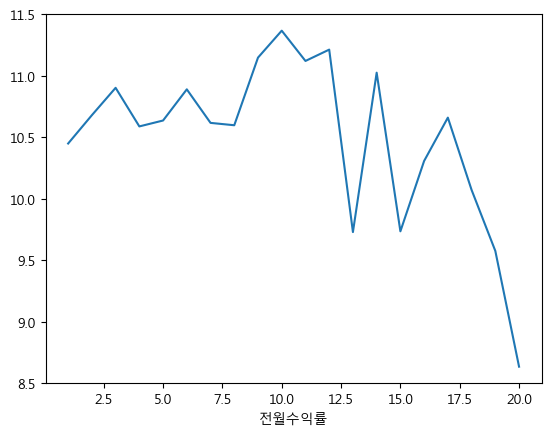

In [174]:
# 이미 오른 주식을 매수해도 상관없을지를 판단하기 위함.
# 전월수익률(매수시점의 한달 수익률)과 다음한달간의 수익률 비교
x = result3["전월수익률"].groupby("매도년월").rank(method="min")
y = result3["수익률"].groupby("매도년월").rank(method="min")
z = pd.concat([x, y], axis=1).groupby("전월수익률")["수익률"].mean()
z.plot()
z

In [111]:
pd.concat([
    revisions,
    revisions["성능"].rolling(6).apply(lambda x: round((x + 1).prod() - 1, 2)).rename("성능 6개월")
], axis=1)

,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률,성능 6개월
매수년월,매도년월,,,,,,
2002-04,2002-05,-0.047674,0.253856,0.30,0.952326,1.253856,NaN
2002-05,2002-06,-0.107912,-0.108834,-0.00,0.849559,1.117394,NaN
2002-06,2002-07,-0.007441,0.060906,0.07,0.843237,1.185449,NaN
2002-07,2002-08,0.033922,0.072438,0.04,0.871842,1.271320,NaN
2002-08,2002-09,-0.156468,-0.038602,0.12,0.735427,1.222245,NaN
...,...,...,...,...,...,...,...
2022-11,2022-12,-0.057066,-0.075052,-0.02,6.368350,13909.567624,0.08
2022-12,2023-01,0.091604,0.122988,0.03,6.951717,15620.276451,0.09
2023-01,2023-02,0.014356,0.005981,-0.01,7.051514,15713.708341,0.10


전체 개월 수       252.000000
초과수익 개월 수     181.000000
누적 성능        2787.103162
dtype: float64

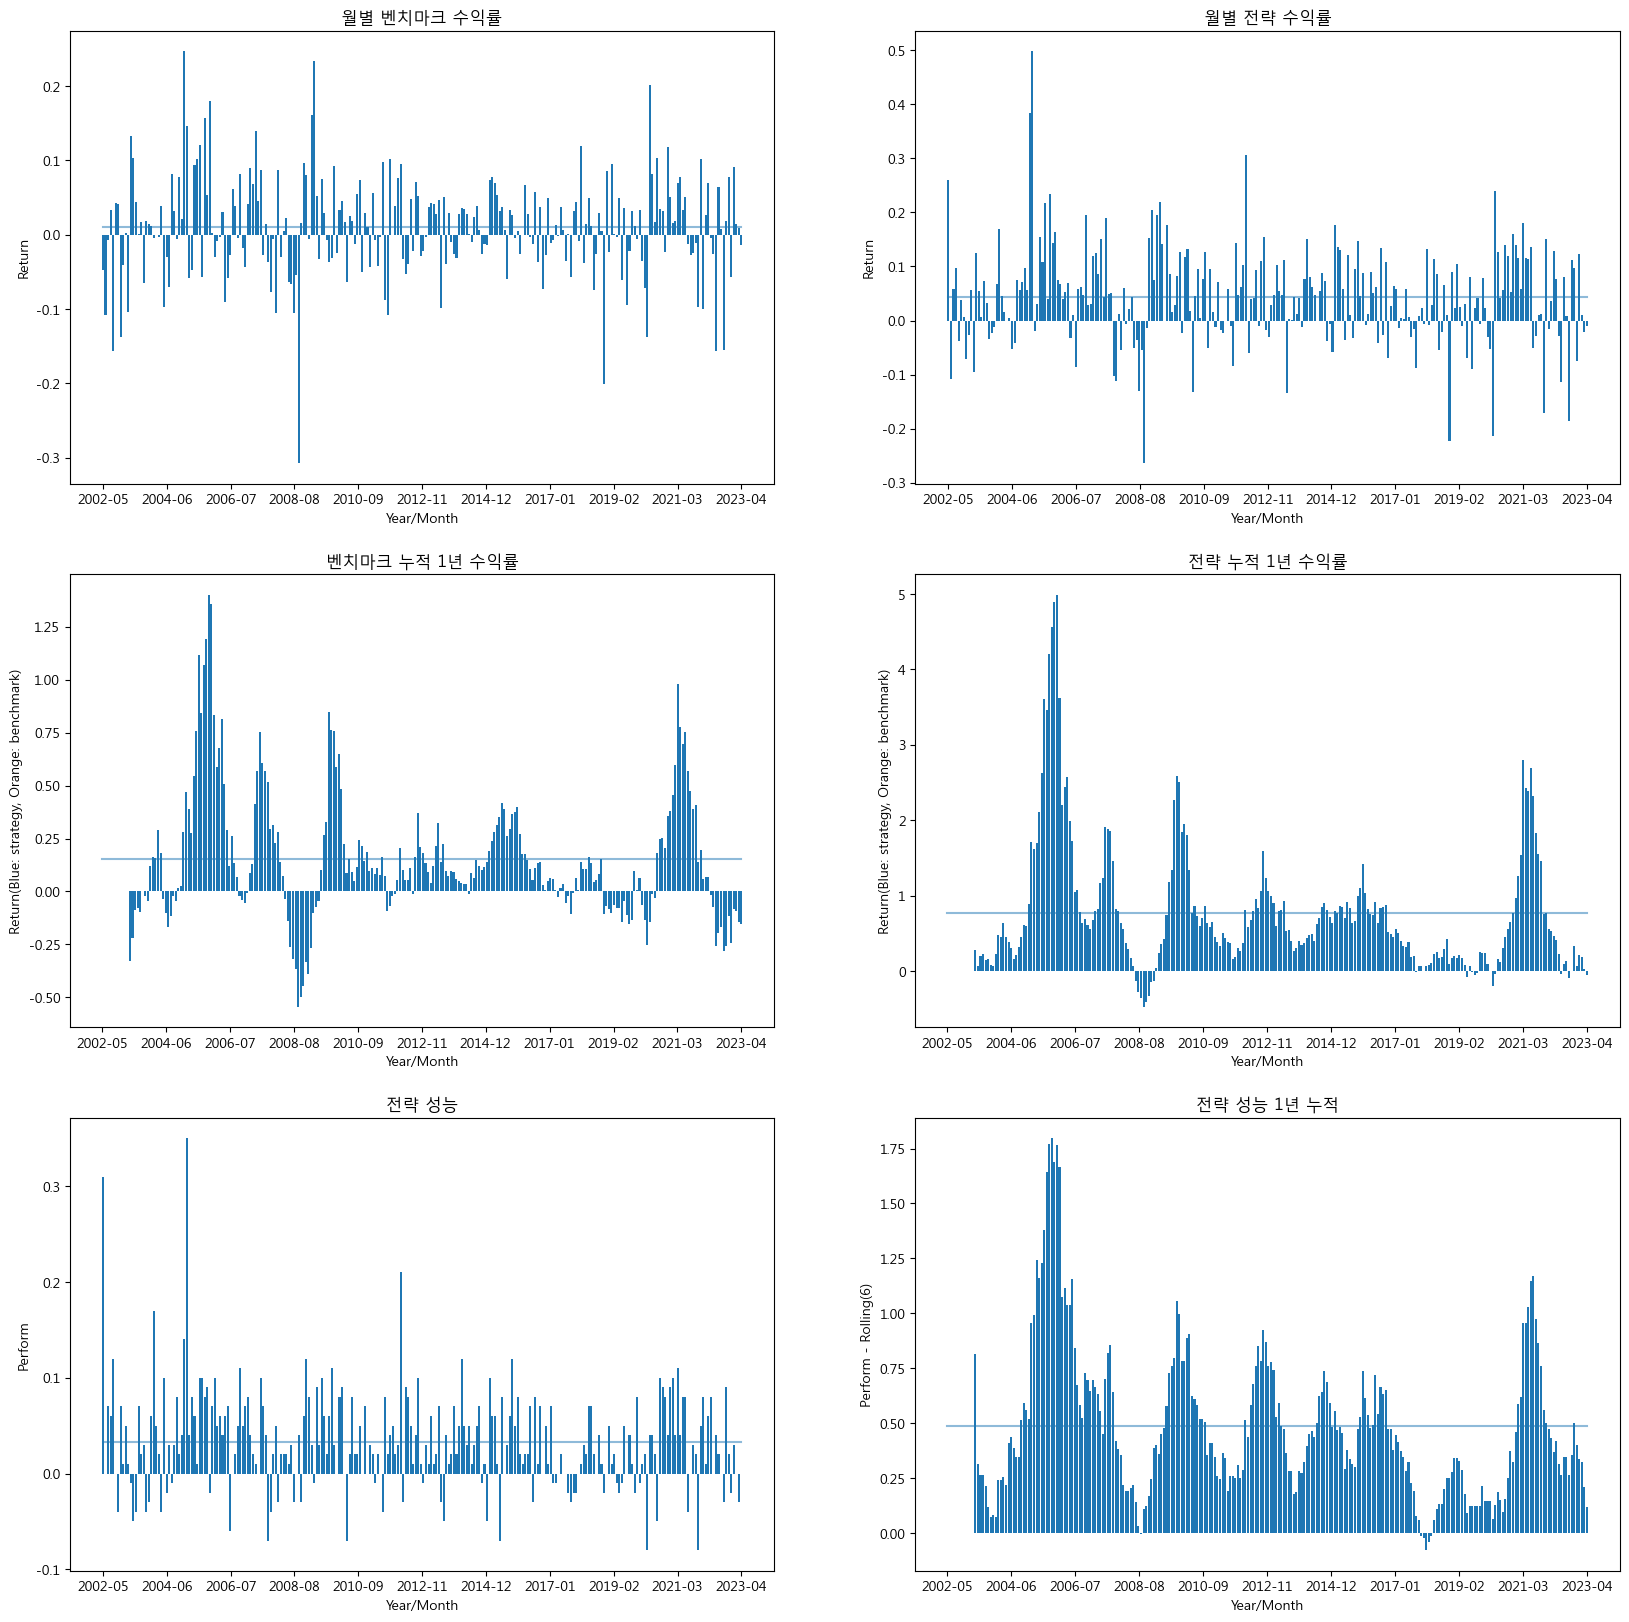

In [7]:
import numpy as np
import matplotlib.pyplot as plt

months = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 벤치마크 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])
ax1.plot(months, [revisions["벤치마크 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"벤치마크 누적 1년 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["벤치마크 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 1년 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})